In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [133]:
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white

def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image


#### Data Cleaning

In [6]:
# Change in paths

In [8]:
img_path = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_434_bbox/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 500
Most common size of the dataset (4, 81, 68)
Final size of dataset(after removing faulty size images) 500
Final size of dataset(after removing faulty black pixels in images) 493
Final size of dataset(after removing faulty white pixels in images) 454


In [11]:
masked_clean = [i for i in clean_3 if 'Masked' in i]
square_clean = [i for i in clean_3 if 'Planet' in i]

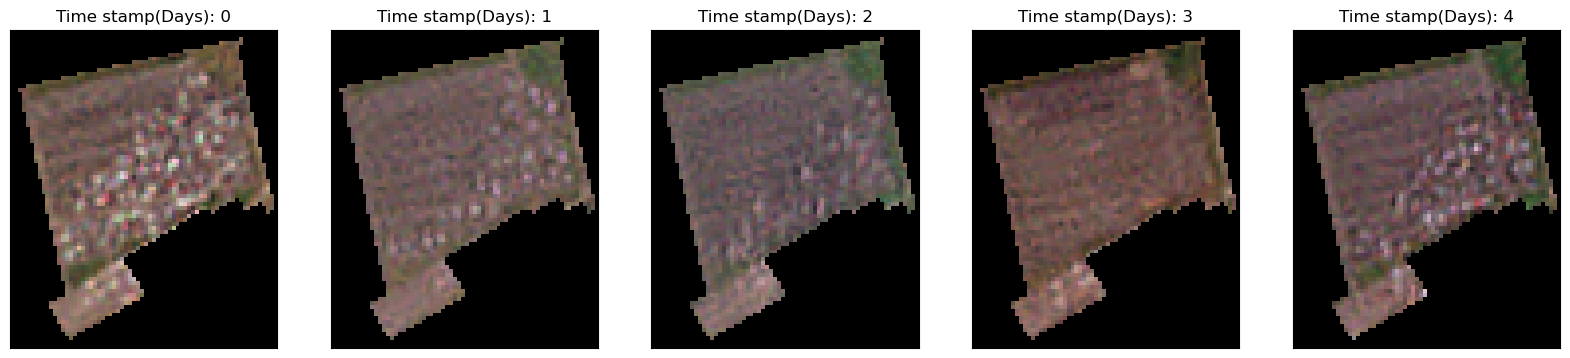

In [15]:
#plot random 5 images from masked_clean
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(masked_clean[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])

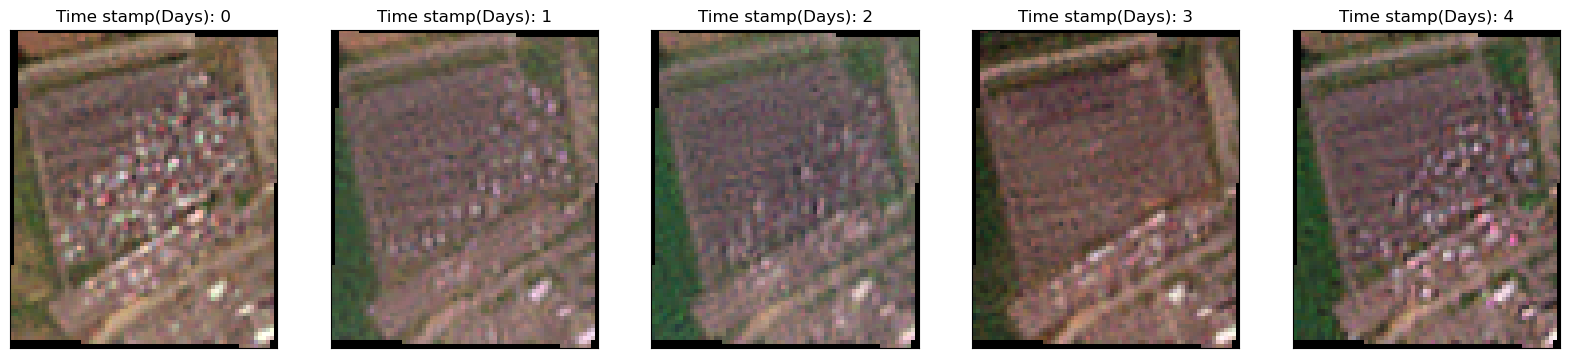

In [16]:
#plot random 5 images from masked_clean
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(square_clean[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])

#### Generate labels

In [20]:
df_masked = label_csv(masked_clean)
df_square = label_csv(square_clean)

Class distribution in dataset: 0    198
1     29
Name: label, dtype: int64
Class distribution in dataset: 0    198
1     29
Name: label, dtype: int64


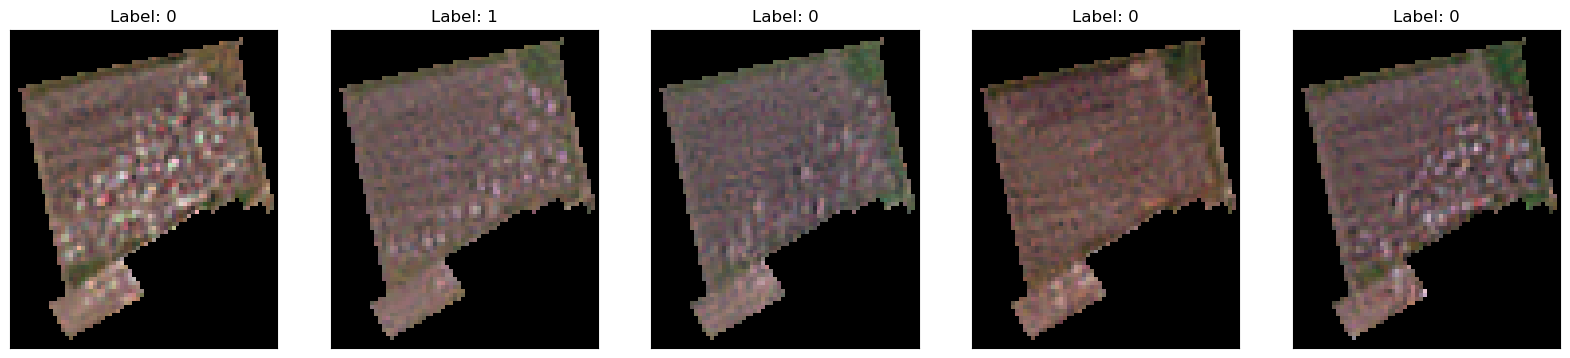

In [132]:
#plot some images from masked_clean with labels
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(df_masked.image_path[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Label: {df_masked.label[i]}')
    plt.xticks([])
    plt.yticks([])

Observations: 
- There is a noise when we are just using week vs Sunday as labels

#### Median Image

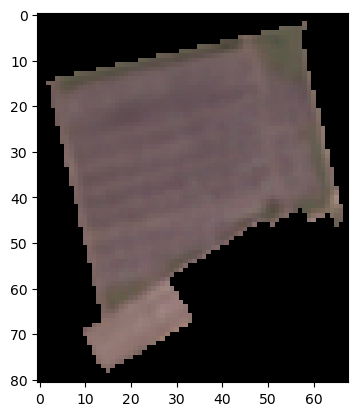

In [136]:
# plot median image
median_img_arr, median_img = create_median_image(df_masked.image_path)
plt.imshow(median_img_arr)

#### Model

In [42]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img = rioxarray.open_rasterio(img_path)
        img = img.data[0:3].transpose(1, 2, 0)
        label = self.df.label.values[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# TODO: Experiment with different transforms later
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

def train(data_frame,train_transform, test_transform, test_size = 0.1, num_epochs = 10, save_path = './models/'):
    train, test = train_test_split(data_frame, test_size=test_size, random_state=42, stratify=data_frame.label.values)
    test.reset_index(inplace=True, drop=True)
    train.reset_index(inplace=True, drop=True)
    print("Train size:", train.shape)
    print("Test size:", test.shape)
    print("Train class distribution:", train.label.value_counts())
    print("Test class distribution:", test.label.value_counts())



    train_dataset = CustomDataset(train, transform=train_transform)
    test_dataset = CustomDataset(test, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = torchvision.models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True
    model.fc = nn.Linear(512, 2)
    model = model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    train_auc = []
    test_auc = []

    best_accuracy = 0.0
    best_AUC = 0.0
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_auc = 0.0
        y_pred = []
        y_true = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # running_auc += roc_auc_score(labels.data.cpu(), outputs.data.cpu()[:,1])
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        epoch_auc = roc_auc_score(y_true, y_pred)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc.item())
        train_auc.append(epoch_auc)
        print('Train Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_acc, epoch_auc))

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        y_pred = []
        y_true = []
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double() / len(test_dataset)
        epoch_auc = roc_auc_score(y_true, y_pred)
        test_loss.append(epoch_loss)
        test_accuracy.append(epoch_acc.item())
        test_auc.append(epoch_auc)
        print('Test Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(epoch_loss, epoch_acc, epoch_auc))

        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            print(("Saving the best model with accuracy {:.4f}").format(best_accuracy))
            torch.save(model.state_dict(), f"{save_path}_acc.pth")
        if epoch_auc > best_AUC:
            best_AUC = epoch_auc
            print(("Saving the best model with AUC {:.4f}").format(best_AUC))
            torch.save(model.state_dict(), f"{save_path}_auc.pth")

    model.load_state_dict(torch.load(f"{save_path}_auc.pth"))

    return model, train_loss, train_accuracy, train_auc, test_loss, test_accuracy, test_auc

### Square_images

In [40]:
model, train_loss_sqr, train_accuracy_sqr, train_auc_sqr, test_loss_sqr, test_accuracy_sqr, test_auc_sqr = train(df_square, train_transform, test_transform, test_size = 0.1, num_epochs = 100)

Train size: (204, 3)
Test size: (23, 3)
Train class distribution: 0    178
1     26
Name: label, dtype: int64
Test class distribution: 0    20
1     3
Name: label, dtype: int64


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------
Train Loss: 0.9619 Acc: 0.7206 AUC: 0.4950
Test Loss: 8.9081 Acc: 0.8696 AUC: 0.5000
Saving the best model with accuracy 0.8696
Saving the best model with AUC 0.5000
Epoch 1/99
----------
Train Loss: 0.5937 Acc: 0.8480 AUC: 0.4860
Test Loss: 0.4097 Acc: 0.8696 AUC: 0.5000
Epoch 2/99
----------
Train Loss: 0.5793 Acc: 0.8725 AUC: 0.5164
Test Loss: 1.4052 Acc: 0.7826 AUC: 0.4500
Epoch 3/99
----------
Train Loss: 0.3943 Acc: 0.8676 AUC: 0.4972
Test Loss: 0.4257 Acc: 0.8696 AUC: 0.5000
Epoch 4/99
----------
Train Loss: 0.3856 Acc: 0.8725 AUC: 0.5000
Test Loss: 0.4774 Acc: 0.8696 AUC: 0.5000
Epoch 5/99
----------
Train Loss: 0.3693 Acc: 0.8725 AUC: 0.5000
Test Loss: 0.4312 Acc: 0.8696 AUC: 0.5000
Epoch 6/99
----------
Train Loss: 0.3701 Acc: 0.8725 AUC: 0.5000
Test Loss: 0.4190 Acc: 0.8696 AUC: 0.5000
Epoch 7/99
----------
Train Loss: 0.3801 Acc: 0.8725 AUC: 0.5000
Test Loss: 0.4812 Acc: 0.8696 AUC: 0.5000
Epoch 8/99
----------
Train Loss: 0.3546 Acc: 0.8725 AUC: 0.500

Text(0.5, 1.0, 'AUC')

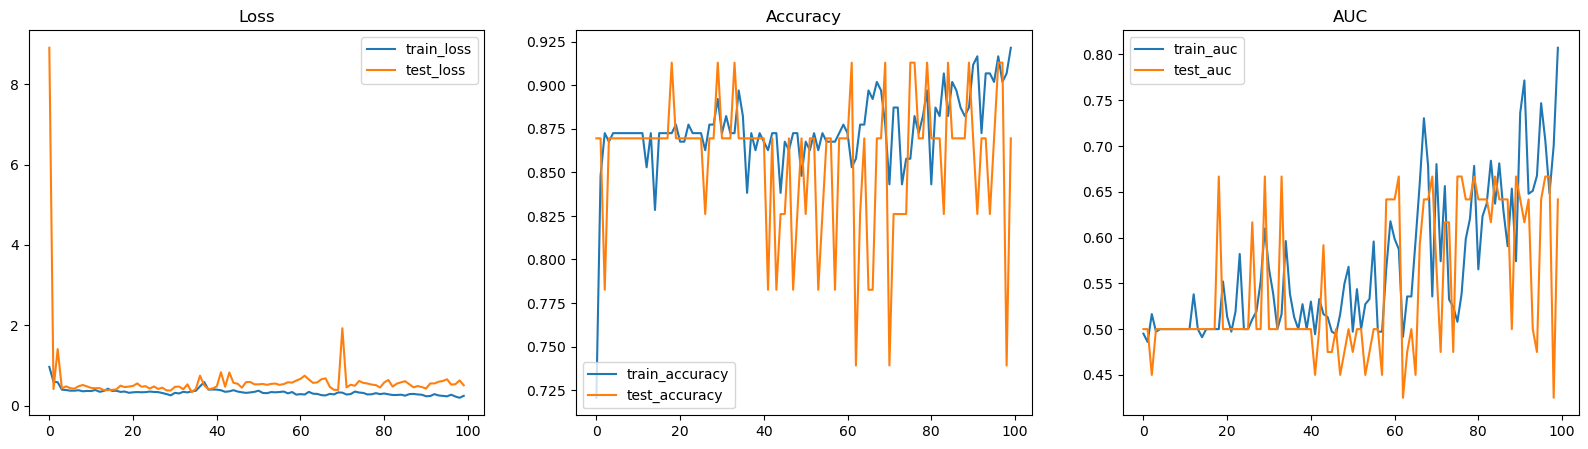

In [41]:
#plot the loss and accuracy and AUC
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(train_loss_sqr, label='train_loss')
plt.plot(test_loss_sqr, label='test_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(train_accuracy_sqr, label='train_accuracy')
plt.plot(test_accuracy_sqr, label='test_accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,3,3)
plt.plot(train_auc_sqr, label='train_auc')
plt.plot(test_auc_sqr, label='test_auc')
plt.legend()
plt.title('AUC')


Masked_images

In [ ]:
def default_collate(batch):
    """
    Override `default_collate` https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader

    Reference:
    def default_collate(batch) at https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader
    https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
    https://github.com/pytorch/pytorch/issues/1512

    We need our own collate function that wraps things up (imge, mask, label).

    In this setup,  batch is a list of tuples (the result of calling: img, mask, label = Dataset[i].
    The output of this function is four elements:
        . data: a pytorch tensor of size (batch_size, c, h, w) of float32 . Each sample is a tensor of shape (c, h_,
        w_) that represents a cropped patch from an image (or the entire image) where: c is the depth of the patches (
        since they are RGB, so c=3),  h is the height of the patch, and w_ is the its width.
        . mask: a list of pytorch tensors of size (batch_size, 1, h, w) full of 1 and 0. The mask of the ENTIRE image (no
        cropping is performed). Images does not have the same size, and the same thing goes for the masks. Therefore,
        we can't put the masks in one tensor.
        . target: a vector (pytorch tensor) of length batch_size of type torch.LongTensor containing the image-level
        labels.
    :param batch: list of tuples (img, mask, label)
    :return: 3 elements: tensor data, list of tensors of masks, tensor of labels.
    """
    data = torch.stack([item[0] for item in batch])
    mask = [item[1] for item in batch]  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    target = torch.LongTensor([item[2] for item in batch])  # image labels.

    return data, mask, target

#### GRAD CAM

#This is wrong, need to perform on sqaure images

In [5]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import torch.nn as nn
import torch


In [6]:
model_test_acc = resnet18(pretrained=False)
model_test_acc.fc = nn.Linear(512, 2)
model_test_acc.load_state_dict(torch.load('/home/akansh-i2sc/Desktop/Project/detect-car-LR/notebooks/Exp_6/models/Resnet18_auc.pth'))
model_test_acc.eval();

/home/akansh-i2sc/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akansh-i2sc/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/akansh-i2sc/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [119]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def plot_gcam(model, path2img, test_transform, mean, std, plot = True):
    img = rioxarray.open_rasterio(path2img)
    img = img.data[0:3].transpose(1, 2, 0)
    input_tensor = test_transform(img)
    input_tensor = input_tensor.to(device)
    target_layers = [model.layer4[-1]] #TODO: Experiment with different layers
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam = 1-grayscale_cam
    inp = std * input_tensor.cpu().numpy().transpose((1, 2, 0)) + mean
    rgb_img = np.clip(inp, 0, 1)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)

    output = model_test_acc(input_tensor.unsqueeze(0))
    pred = torch.argmax(output, dim=1).cpu().item()
    print("Predicted label:", pred)
    date_in = path2img.split('/')[-1][:8]
    year = date_in[0:4]
    month = date_in[4:6]
    day = date_in[6:8]
    date_string = f"{year}-{month}-{day}"
    print("Day:", find_day(date_string))
    if find_day(date_string) == 'Sunday':
        print("True label: 1")
    else:
        print("True label: 0")

    #plot original image and gradcam image
    if plot:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.imshow(visualization)

    return img, visualization

In [7]:
_, _ = plot_gcam(model_test_acc, masked_clean[1], test_transform, mean, std)

NameError: name 'plot_gcam' is not defined